In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import random
import math
import time
import os

from scipy import stats
from scipy.stats import permutation_test
from scipy.stats import chisquare
from scipy.stats import kstest

In [2]:
palette = ['#6D9BC3', '#AF4035', '#00937F', '#F0DD67', '#7B5141',
           '#4A4E69', '#B86A84', '#587B7F', '#9DA3A6', '#505050']

In [3]:
custom_params = {
    'figure.figsize': (6, 4), # ширина и высота в дюймах
    'axes.titlesize': 13, # заголовок
    'axes.labelsize': 13, # оси
    'xtick.labelsize': 11, # деления оси X
    'ytick.labelsize': 11, # деления оси Y
    'axes.spines.left': False, # не отображать ось Y
    'axes.spines.right': False, # не отображать правую рамку 
    'axes.spines.top': False, # не отображать верхнюю рамку
    'axes.spines.bottom': True, # отображать нижнюю рамку
    'grid.color': '0.9',
    'grid.linestyle': ':',
    'lines.linewidth': 2,
}

sns.set_theme(style='whitegrid', palette=palette, rc=custom_params)

%matplotlib inline

seed = 42

### Data

In [4]:
x = np.random.poisson(150, 10000)
y = np.random.lognormal(5, 0.5, 10000)

In [5]:
data = pd.DataFrame([x,y]).T.rename(columns={0: 'x', 1: 'y'})

In [6]:
data.head()

,x,y
0,156.0,54.336161
1,160.0,94.351239
2,133.0,232.376758
3,139.0,126.298303
4,142.0,187.854253


In [7]:
x.mean()

149.9091

In [8]:
y.mean()

167.7498234887043

In [9]:
x.mean() - y.mean()

-17.8407234887043

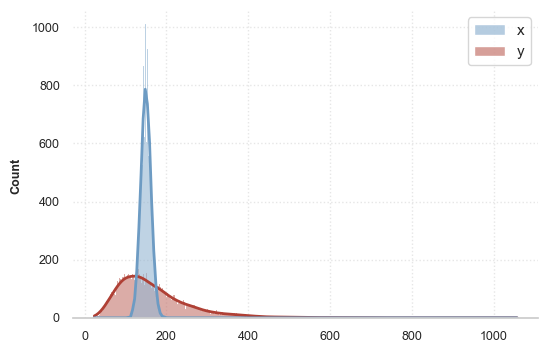

In [10]:
ax = sns.histplot(data=data, kde=True)

ax.tick_params(axis='both', which='major', labelsize=9)
ax.set(xlabel=None)
ax.set_ylabel('Count', fontsize=9, weight='bold')
ax.yaxis.set_label_coords(-0.11,0.46)

### Poisson Bootstrap

Проверяет гипотезу о различии общегрупповых средних.

In [11]:
def test_poisson_bootstrap(data1, data2, n_bootstrap=10000, ci=[2.5,97.5],
                           plot=True, execution_time=False, results_dict=True, means_plots=True):
    
    t_start = time.time()
    
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)

    means_diff = mean1 - mean2

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(data1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(data2))).astype(np.int64)

    mean1_boot = (poisson_bootstraps1*data1).sum(axis=1) / len(data1)
    mean2_boot = (poisson_bootstraps2*data2).sum(axis=1) / len(data2)
    means_diff_boot = mean1_boot - mean2_boot
    
    lower_boundary, upper_boundary = np.percentile(means_diff_boot, ci)
    
    means_dict = {
        'mean1': mean1_boot,
        'mean2': mean2_boot,
        'means_diff': means_diff_boot
    }
    
    results = {
        'Lower Boundary': lower_boundary, 
        'Means Difference': means_diff, 
        'Upper Boundary': upper_boundary
    }

    if plot:

        ax = sns.histplot(
            means_diff_boot,
            color=palette[0], alpha=0.8
        )

        ylim = ax.get_ylim()[1]
        
        ax.vlines(
            0, 0, ylim*0.1,
            color=palette[1], linewidth=2.5
        )
        ax.vlines(
            lower_boundary, 0, ylim*0.15,
            color=palette[9], linewidth=1.5
        )
        ax.vlines(
            upper_boundary, 0, ylim*0.15,
            color=palette[9], linewidth=1.5
        ) 

        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.set_xlabel('Means Difference', fontsize=9, weight='bold')
        ax.set_ylabel('Count', fontsize=9, weight='bold')
        ax.xaxis.set_label_coords(0.5, -0.13)
        ax.yaxis.set_label_coords(-0.11, 0.46)
        
        plt.show()
        
    # the boundaries, measured by 1 and 99 percentiles,
    # are equvivalent of p-value probabiblities boundaries an 0.05 significant level;
    # if difference in means is out of boundaries range, we reject null hypotesis - 
    # it means that the difference if statistical significant
    if lower_boundary < 0 < upper_boundary:
        significancy = 'No'
    else: 
        significancy = 'Yes'
    
    # check with Kolmogorov–Smirnov test if distribution of p-values is normal
    # (previously standardize means differences with stats.zscore)
    pvalue_ks = stats.kstest(stats.zscore(means_diff_boot), stats.norm.cdf).pvalue
    
    # Kolmogorov–Smirnov test null hypotesis: distribution of simulation pvalues is normal
    # if pvalue due Kolmogorov–Smirnov test <= 0.05, 
    # we reject null hypotesis that distribution of pvalues due simulation is normal;  
    if pvalue_ks <= 0.05:
        distribution = 'not '
    else:
        distribution = ''
    
    
    if execution_time:
        
        execution_time = np.round(time.time() - t_start, 2)
        execution_time_formated = \
                         str(dt.timedelta(seconds=np.round(time.time() - t_start)))
        
        print('Execution time: {}'.format(execution_time_formated))
        print('Execution time (seconds): {}'.format(execution_time, '\n'))
    
    print('\n'
          'Significancy: \033[1m{0}\033[0m' '\n' '\n' 
          "Means Differences' distribution: {1}normal." '\n' 
          'Kolmogorov–Smirnov test p-value: {2}' '\n' '\n'
          'Mean1: {3}' '\n'
          'Mean2: {4}' '\n' '\n'
          'Lower Boundary: {5}' '\n'
          'Means Difference: {6}' '\n'
          'Upper Boundary: {7}'.format(significancy,
                                       distribution,
                                       np.round(pvalue_ks, 2),
                                       mean1,
                                       mean2,
                                       lower_boundary,
                                       means_diff,
                                       upper_boundary))
    
    plt.show()
    
    if means_plots:
        
        print('')
        
        ax = sns.histplot(
            mean1_boot,
            color=palette[0], alpha=0.6
        )
        
        ax = sns.histplot(
            mean2_boot, 
            color=palette[1], alpha=0.6
        )
        
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.set(xlabel=None)
        ax.set_ylabel('Count', fontsize=9, weight='bold')
        ax.yaxis.set_label_coords(-0.11,0.46)
        
        ylim = ax.get_ylim()[1]
        
        ax.vlines(
            np.mean(mean1_boot), 0, ylim,
            color=palette[9], linewidth=1
        )
        ax.vlines(
            np.mean(mean2_boot), 0, ylim,
            color=palette[9], linewidth=1
        )
        
        plt.show()
    
    if results_dict:
        return results, means_dict

In [12]:
# convert to np.array

# x = x.to_numpy()
# y = y.to_numpy()

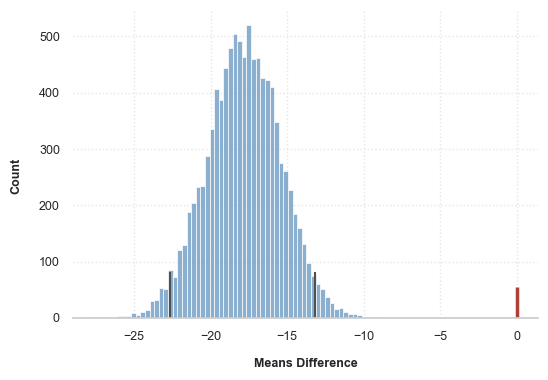

Execution time: 0:00:22
Execution time (seconds): 21.91

Significancy: Yes

Means Differences' distribution: normal.
Kolmogorov–Smirnov test p-value: 0.93

Mean1: 149.9091
Mean2: 167.7498234887043

Lower Boundary: -22.667760039397663
Means Difference: -17.8407234887043
Upper Boundary: -13.166890480254184



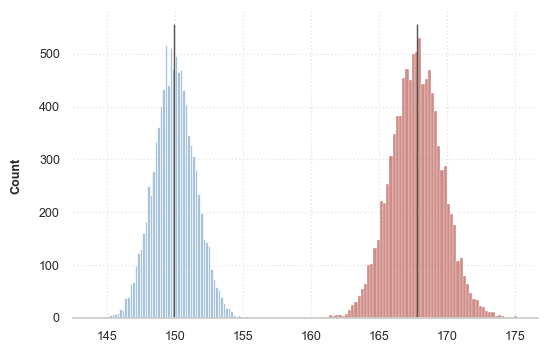

In [13]:
poisson_dict, poisson_means_dict = test_poisson_bootstrap(
    data1=x,
    data2=y,
    n_bootstrap=10000,
    plot=True,
    execution_time=True,
    results_dict=True,
    means_plots=True
)

### T-test

Проверяет гипотезу о статистически значимых различиях двух выборок.

Нулевая гипотеза отвергается если получившееся распределение p-values непрерывное и равномерное (**continuous uniform distribution** or **rectangular distribution**) 

Критерий Колмогорова-Смирнова показывает, отличается ли получившееся распределение p-значений от непрерывного равномерного.

In [14]:
def test_simulation_ttest(data1, data2, sample_length=50, n_samples=10000,
                          replace=True, execution_time=True, plot=True):
    
    t_start = time.time() 
    array = np.array([])
    
    for i in range(n_samples):
        
        sampling1 = data1.sample(sample_length, replace=replace)
        sampling2 = data2.sample(sample_length, replace=replace)
        
        pvalue_simulation = stats.ttest_ind(
            sampling1,
            sampling2,
            equal_var=False
        ).pvalue
        
        array = np.append(array, pvalue_simulation)
    
    # number of p-values less or equal 0.05
    p_significant = np.sum(np.where(array <= 0.05, 1, 0))
    
    # fraction of p-values less or equal 0.05
    p_significant_fraction = np.around(p_significant / len(array), 2)
    
    # check with Kolmogorov–Smirnov test if distribution of p-values is uniform
    uniform_distribution = stats.uniform.rvs(size=10000, random_state=42)
    pvalue_ks = stats.kstest(array, uniform_distribution).pvalue
    
    # Kolmogorov–Smirnov test null hypotesis: distribution of simulation pvalues is uniform
    # if pvalue due Kolmogorov–Smirnov test <= 0.05, 
    # we reject null hypotesis that distribution of pvalues due simulation is unoform;
    # also we have to check, that fractions ov simulation pvalues is more than
    # 0.05 - it says, that simulation distribution skewed to pvalues <= 0.05 side
    significancy = 'Yes' if pvalue_ks <= 0.05 and \
                            p_significant_fraction >= 0.05 else 'No'
    
    if significancy == 'Yes':
        distribution = 'not '
    else:
        distribution = ''
    
    if plot:
    
        plt.figure(figsize=(6,3))

        ax = sns.histplot(
            data=array,
            bins=20, alpha=1
        )
        
        ax.set_title('Simulation Results', fontsize=11, weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.set_xlabel('P-value', fontsize=9, weight='bold')
        ax.set_ylabel('Count', fontsize=9, weight='bold')
        ax.xaxis.set_label_coords(0.5, -0.15)
        ax.yaxis.set_label_coords(-0.11,0.46)
    
    plt.show()
    
    if execution_time:
        
        execution_time = np.round(time.time() - t_start, 2)
        execution_time_formated = str(dt.timedelta(seconds=np.round(time.time() - t_start)))
        
        print('Execution time: {}'.format(execution_time_formated))
        print('Execution time (seconds): {}'.format(execution_time, '\n'))
        
    print('\n' \
          'Significancy: \033[1m{0}\033[0m' '\n' '\n' 
          'Fraction of p-values (0.05 or less): {1}' '\n' '\n' 
          "P-value's distribution: {2}uniform." '\n' 
          'Kolmogorov–Smirnov test p-value: {3}'  
          .format(significancy, p_significant_fraction, distribution, pvalue_ks)) 

In [15]:
x = pd.Series(x)
y = pd.Series(y)

In [16]:
sample_length = 100
n_samples = 10000

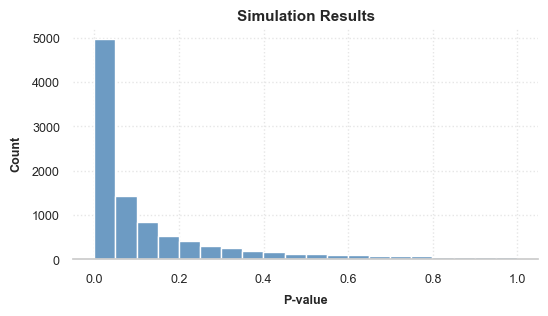

Execution time: 0:00:06
Execution time (seconds): 5.83

Significancy: Yes

Fraction of p-values (0.05 or less): 0.5

P-value's distribution: not uniform.
Kolmogorov–Smirnov test p-value: 0.0


In [17]:
test_simulation_ttest(
    data1=x, data2=y,
    sample_length=sample_length,
    n_samples=n_samples,
    replace=True,
    execution_time=True,
    plot=True
)

### Permutation Test

Проеряет гипотезу о статистически значимом различии двух выборок.

**Randomized**=True - for big datasets

In [18]:
def statistic(data1, data2, axis=0):
    return np.mean(data1, axis=axis) - np.mean(data2, axis=axis)

def test_permutation(data1, data2, statistic, vectorized=True, randomized=True, 
                     n_resamples=10000, execution_time=True):
    
    t_start = time.time()
    
    resamples = n_resamples if randomized else np.inf    
    
    res = stats.permutation_test(
        (data1, data2),
        statistic,
        vectorized=True, 
        n_resamples=resamples,
        alternative='less'
    )
    
    diff = res.statistic
    pvalue = res.pvalue
    
    # if p-value <= 0.05 we reject null hypotesis - 
    # the difference if statistical significant
    significancy = 'Yes' if pvalue <= 0.05 else 'No'
        
    
    if execution_time:
        
        execution_time = np.round(time.time() - t_start, 2)
        execution_time_formated = str(dt.timedelta(seconds=np.round(time.time() - t_start)))
        
        print('Execution time: {}'.format(execution_time_formated))
        print('Execution time (seconds): {}'.format(execution_time, '\n'))
    
    print('\n' \
          'Significancy: \033[1m{0}\033[0m' '\n' '\n' \
          'P-value: {1}' '\n' \
          'Statistic: {2}' '\n' '\n' \
          'Statistic type: Means Difference' '\n' \
          .format(significancy, pvalue, diff))
    
    return res

In [19]:
res = test_permutation(
    data1=x,
    data2=y,
    statistic=statistic,
    vectorized=True,
    randomized=True,
    execution_time=True
)

Execution time: 0:00:21
Execution time (seconds): 21.46

Significancy: Yes

P-value: 9.999000099990002e-05
Statistic: -17.8407234887043

Statistic type: Means Difference



In [20]:
res.statistic

-17.8407234887043

In [21]:
res.pvalue

9.999000099990002e-05

In [22]:
res.null_distribution

array([0.10291462, 0.14986732, 0.0089876 , ..., 1.14711467, 0.29473166,
       0.37560721])